# Project: Emerging Markets from Tax Data

* The IRS supplies personal income tax statistics organized by zipcode.

* Objective: Find regions experiencing economic growth, and figure out what makes them that way.

* Criteria: growth rate above threshold in certain income bracket? minimal number of people?

In [31]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import xgboost as xgb
import sklearn
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook
from bokeh.embed import components
output_notebook()

import seaborn as sns
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

Loading BokehJS ...

In [2]:
def import_data(years):
    '''
    Import tax data into a dictionary of pandas Dataframes
    '''
    labels = {'n1': 'num_returns','n2' : 'num_exemp', 'a00100' : 'agi'}
    tax_data = {}
    for year in years:
        tax_data[year] = pd.read_csv('../Data Incubator/20'+year+'zipcode/'+year+'zpallagi.csv',na_values=['.'])
        tax_data[year].columns = [x.lower() for x in tax_data[year].columns]
        tax_data[year].rename(columns = labels, inplace = True)
    return tax_data

In [3]:
years = [str(i).zfill(2) for i in xrange(5,15)]
tax_data = import_data(years)
tax_data['12'].head()

/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,statefips,state,zipcode,agi_stub,num_returns,mars1,mars2,mars4,prep,num_exemp,...,n09600,a09600,n06500,a06500,n10300,a10300,n11901,a11901,n11902,a11902
0,1,AL,0,1,889920.0,490850.0,129070.0,256900.0,526740.0,1505430.0,...,0.0,0.0,269140.0,168057.0,387720.0,314297.0,59310.0,40782.0,785950.0,2040191.0
1,1,AL,0,2,491150.0,194370.0,159200.0,123350.0,293480.0,1034650.0,...,0.0,0.0,370140.0,854669.0,389320.0,937609.0,62450.0,85568.0,421290.0,1185415.0
2,1,AL,0,3,254280.0,68160.0,148960.0,31480.0,157230.0,591880.0,...,100.0,73.0,242260.0,1214154.0,245280.0,1286668.0,55290.0,113674.0,193020.0,550512.0
3,1,AL,0,4,160160.0,23020.0,126140.0,9030.0,97620.0,420830.0,...,260.0,318.0,158560.0,1281451.0,158980.0,1342424.0,38890.0,104526.0,116570.0,388708.0
4,1,AL,0,5,183320.0,15880.0,161260.0,4890.0,110520.0,517060.0,...,2350.0,4924.0,182620.0,3193351.0,182800.0,3319526.0,66910.0,323614.0,108270.0,430314.0


In [20]:
def find_agi_data(years):
    agi_data = {}
    for year in years:
        agi_data[year] = tax_data[year][['state','zipcode', 'agi', 'num_returns', 'num_exemp']].groupby(['state', 'zipcode'],as_index=False).sum().copy()
        agi_data[year] = agi_data[year][agi_data[year]['num_returns']>250]
        agi_data[year] = agi_data[year][agi_data[year]['zipcode']>0]
        agi_data[year] = agi_data[year][['state', 'agi', 'num_returns', 'num_exemp']].groupby('state',as_index=False).sum().copy()
        labels = {'num_returns':'num_returns'+year, 'num_exemp':'num_exemp'+year, 'agi':'agi'+year}
        agi_data[year].rename(columns = labels, inplace = True)
        agi_data[year]['state'] = map(lambda x: x.upper(), agi_data[year]['state'])
        if year in ['07','08']:
            agi_data[year]['agi'+year] = agi_data[year]['agi'+year]/1000
    return reduce(lambda left,right: pd.merge(left,right,on='state'), [agi_data[year] for year in years])

In [21]:
agi_data = find_agi_data(years)

In [8]:
inflation_rate = {'05':3.42,'06':2.54,'07':4.08,\
                  '08':0.09,'09':2.72,'10':1.50,'11':2.96,\
                 '12':1.74,'13':1.50,'14':0.76}

In [22]:
for i in xrange(len(years)-1):
    agi_data['growth'+years[i]+years[i+1]] = agi_data['agi'+years[i+1]]/agi_data['agi'+years[i]] - 1 - inflation_rate[years[i+1]]/100

In [23]:
agi_data.set_index('state', inplace=True)

In [ ]:
pd.read_csv

In [24]:
growth_list = ['growth'+years[i]+years[i+1] for i in xrange(len(years)-1)]
agi_data['growth_coef'] = agi_data[growth_list].mean(axis=1)
agi_data.head()

,agi05,num_returns05,num_exemp05,agi06,num_returns06,num_exemp06,agi07,num_returns07,num_exemp07,agi08,...,growth0506,growth0607,growth0708,growth0809,growth0910,growth1011,growth1112,growth1213,growth1314,growth_coef
state,,,,,,,,,,,,,,,,,,,,,
AK,15778127,317182,616249,1.695910e+07,312186.0,570664.0,1.891624e+07,339372,610005,1.990520e+07,...,0.049449,0.074603,0.051381,-0.218592,0.064270,0.229198,0.026495,-0.008285,0.051077,0.035511
AL,86270947,1898317,4070115,9.308527e+07,1959259.0,4034508.0,1.002437e+08,2280197,4461764,9.770659e+07,...,0.053587,0.036102,-0.026210,-0.079739,0.022473,0.017334,0.026750,-0.016327,0.029013,0.006998
AR,46337142,1102876,2368065,4.898687e+07,1134118.0,2348873.0,5.355790e+07,1337291,2620417,5.288994e+07,...,0.031784,0.052511,-0.013372,-0.044594,0.031539,0.045015,0.043488,-0.024044,0.046503,0.018759
AZ,133792115,2396072,5183757,1.449254e+08,2503374.0,5280920.0,1.527453e+08,2789719,5718890,1.417243e+08,...,0.057813,0.013158,-0.073053,-0.146277,0.061778,0.059211,0.049081,-0.002087,0.047702,0.007481
CA,948033818,14936761,32143396,1.013487e+09,15365727.0,32022679.0,1.099010e+09,16905770,34257517,1.029954e+09,...,0.043641,0.043585,-0.063735,-0.083708,0.050143,0.033349,0.077153,-0.011413,0.079417,0.018715


In [25]:
agi_data[['agi07','agi08','agi09','agi10','num_returns07','num_returns08','num_returns09','num_returns10']]

,agi07,agi08,agi09,agi10,num_returns07,num_returns08,num_returns09,num_returns10
state,,,,,,,,
AK,1.891624e+07,1.990520e+07,1.609550e+07,1.737138e+07,339372,334065,2.726380e+05,2.870690e+05
AL,1.002437e+08,9.770659e+07,9.257320e+07,9.604224e+07,2280197,2016100,1.965325e+06,1.994415e+06
AR,5.355790e+07,5.288994e+07,5.196999e+07,5.438863e+07,1337291,1173556,1.130077e+06,1.145939e+06
AZ,1.527453e+08,1.417243e+08,1.248482e+08,1.344338e+08,2789719,2618932,2.355618e+06,2.497681e+06
CA,1.099010e+09,1.029954e+09,9.717535e+08,1.035057e+09,16905770,15896832,1.556285e+07,1.584999e+07
CO,1.492393e+08,1.420961e+08,1.319574e+08,1.408567e+08,2370757,2271125,2.180468e+06,2.231876e+06
CT,1.560151e+08,1.424630e+08,1.345668e+08,1.465704e+08,1821544,1705062,1.664968e+06,1.684305e+06
DC,2.301578e+07,2.216966e+07,2.242982e+07,2.419382e+07,303737,292785,3.011580e+05,3.131110e+05
DE,2.488952e+07,2.373831e+07,2.280809e+07,2.350474e+07,441734,414543,4.090000e+05,4.170590e+05


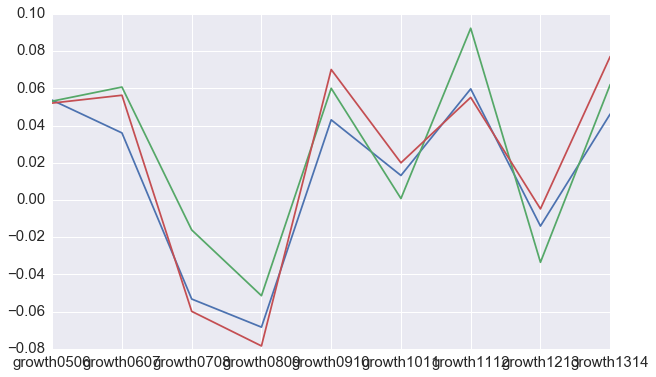

In [27]:
rand_rows = [np.random.randint(1,50) for i in xrange(3)]
growth_list = ['growth'+years[i]+years[i+1] for i in xrange(len(years)-1)]
for row in rand_rows:
    agi_data[growth_list].iloc[row].plot()

In [28]:
agi_data.to_csv('agi_data')

In [111]:
pd.read_csv('agi_data', index_col = 0)

,agi05,num_returns05,num_exemp05,agi06,num_returns06,num_exemp06,agi07,num_returns07,num_exemp07,agi08,...,growth0506,growth0607,growth0708,growth0809,growth0910,growth1011,growth1112,growth1213,growth1314,growth_coef
state,,,,,,,,,,,,,,,,,,,,,
AK,15778127,317182,616249,1.695910e+07,312186.0,570664.0,1.891624e+07,339372,610005,1.990520e+07,...,0.049449,0.074603,0.051381,-0.218592,0.064270,0.229198,0.026495,-0.008285,0.051077,0.035511
AL,86270947,1898317,4070115,9.308527e+07,1959259.0,4034508.0,1.002437e+08,2280197,4461764,9.770659e+07,...,0.053587,0.036102,-0.026210,-0.079739,0.022473,0.017334,0.026750,-0.016327,0.029013,0.006998
AR,46337142,1102876,2368065,4.898687e+07,1134118.0,2348873.0,5.355790e+07,1337291,2620417,5.288994e+07,...,0.031784,0.052511,-0.013372,-0.044594,0.031539,0.045015,0.043488,-0.024044,0.046503,0.018759
AZ,133792115,2396072,5183757,1.449254e+08,2503374.0,5280920.0,1.527453e+08,2789719,5718890,1.417243e+08,...,0.057813,0.013158,-0.073053,-0.146277,0.061778,0.059211,0.049081,-0.002087,0.047702,0.007481
CA,948033818,14936761,32143396,1.013487e+09,15365727.0,32022679.0,1.099010e+09,16905770,34257517,1.029954e+09,...,0.043641,0.043585,-0.063735,-0.083708,0.050143,0.033349,0.077153,-0.011413,0.079417,0.018715
CO,124067044,2089317,4303030,1.363079e+08,2155085.0,4268177.0,1.492393e+08,2370757,4571051,1.420961e+08,...,0.073263,0.054069,-0.048764,-0.098551,0.052441,0.051442,0.071967,-0.008480,0.084840,0.025803
CT,129784885,1638225,3255668,1.395598e+08,1672821.0,3140213.0,1.560151e+08,1821544,3312861,1.424630e+08,...,0.049917,0.077108,-0.087764,-0.082626,0.074202,-0.024633,0.069725,-0.043869,0.047919,0.008887
DC,19144336,270640,444869,2.079332e+07,277018.0,440645.0,2.301578e+07,303737,470854,2.216966e+07,...,0.060735,0.066083,-0.037663,-0.015465,0.063645,0.027817,0.068700,-0.025038,0.082512,0.032370
DE,22604855,392310,784934,2.347970e+07,401449.0,770849.0,2.488952e+07,441734,824905,2.373831e+07,...,0.013302,0.019244,-0.047153,-0.066386,0.015544,0.022673,0.042830,-0.008213,0.043859,0.003967


In [56]:
plot_data = agi_data[['agi05','agi06','agi07','agi08','agi09','agi10','agi11','agi12','agi13','agi14']]
plot_data.loc['NY']/10**6

agi05    539.751931
agi06    591.279880
agi07    665.654971
agi08    623.335651
agi09    590.142680
agi10    629.257880
agi11    657.686519
agi12    710.372835
agi13    712.668060
agi14    765.615054
Name: NY, dtype: float64

In [102]:
def make_translator():
    states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
    }
    abbr_translator = {}
    for state in states:
        abbr_translator[states[state]] = state
        abbr_translator[state] = states[state]
    return abbr_translator

In [107]:
def toggle_abbr(states):
    return map(lambda x: abbr_translator[x], state_list)

In [109]:
state_list = toggle_abbr(state_list)

In [110]:
import itertools

# define the color palette
ncolors = 5
palette = sns.palettes.color_palette('colorblind', ncolors)
# as hex is necessary for bokeh to render the colors properly.
colors = itertools.cycle(palette.as_hex())

plot = figure(plot_width=400, plot_height=400,\
             title = 'Total Adjusted Gross Income',
             x_axis_label = 'Year',
             y_axis_label = 'AGI ($ millions)')


for state, color in itertools.izip(toggle_abbr(state_list), colors):
    plot.line([5,6,7,8,9,10,11,12,13,14],plot_data.loc[state]/10**6,line_width=3,legend = state,line_color = color)
show(plot)

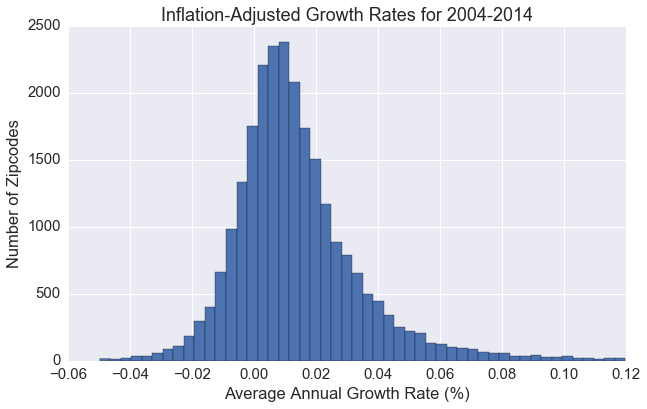

In [45]:
agi_data['growth_coef'][(agi_data['growth_coef']>-0.05) & (agi_data['growth_coef']<0.12)].hist(bins=50)
plt.title('Inflation-Adjusted Growth Rates for 2004-2014')
plt.xlabel('Average Annual Growth Rate (%)')
plt.ylabel('Number of Zipcodes')
plt.show()

## Geographical Map of Income

* A heat map of the average growth rates, shaded zipcode by zipcode.

* The middle of the country has the best growth rates!

In [18]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import shapefile as shp

In [27]:
sf = shp.Reader('cb_2014_us_zcta510_500k/cb_2014_us_zcta510_500k')
shapes = sf.shapes()
records = sf.records()
zipcodes = [int(record[0]) for record in records]

In [39]:
def draw_map(map_data, min_quant, max_quant, cbar = False):

    #map_min = map_data.quantile(min_quant)
    #map_max = map_data.quantile(max_quant)
    map_min = -0.03
    map_max = 0.03
    map_norm = map_max - map_min

    if cbar == False:
        map_data = map_data[(map_data < map_max) & (map_data > map_min)].dropna()


    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    #cmap = plt.cm.Reds
    #cmap = plt.cm.coolwarm
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    
    my_map = Basemap(projection='lcc', lat_0=57, lon_0=-95, resolution = 'l',\
        llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,lat_1=33,lat_2=45)
 
    my_map.drawcoastlines()
    my_map.drawcountries()
    #my_map.fillcontinents(color='coral')
    my_map.drawmapboundary()
    #my_map.drawmeridians(np.arange(0, 360, 30))
    #my_map.drawparallels(np.arange(-90, 90, 30))
    
    
    for i, value in enumerate(map_data):
        zipcode = map_data.index[i]
        if cbar:
            fc = cmap((value-map_min)/map_norm)
        else:
            fc = 'red'
            
        shape = shapes[zipcodes.index(zipcode)]
        lons,lats = zip(*shape.points)
        x, y = my_map( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=fc, edgecolor = fc, alpha=1 )
        plt.gca().add_patch(poly)
    
    '''
    for record, shape in zip(records,shapes):
        zipcode = int(record[0])
        try:
            value = map_data.loc[zipcode]
            if cbar:
                fc = cmap((value-map_min)/map_norm)
            else:
                fc = 'red'
        except KeyError:
            fc = 'none'
        lons,lats = zip(*shape.points)
        x, y = my_map( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=fc, edgecolor = fc, alpha=1 )
        plt.gca().add_patch(poly)  
    '''        
    if cbar:
        plt.title('Zipcodes Shaded by Growth Rate')
    else:
        plt.title('Zipcodes Having AGI per Exemption Between \$ {0:.0f}k and \$ {1:.0f}k'.format(map_min, map_max))

    if cbar:
        cax = plt.gcf().add_axes([0.95, 0.2, 0.02, 0.6])
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional',ticks=[0, 0.5, 1])
        cb.set_label('Annual Growth Rate')
        cb.ax.set_yticklabels(['<{:.0f}%'.format(map_min*100),\
                               '{:.0f}%'.format(100*(map_min+map_max)/2),'>{:.0f}%'.format(100*map_max)])
    
    
    plt.show()

In [20]:
plot_data = agi_data['growth_coef'][(agi_data['growth_coef']>-0.05) & (agi_data['growth_coef']<0.12)]

/Users/stefan/anaconda/lib/python2.7/site-packages/seaborn/palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
/Users/stefan/anaconda/lib/python2.7/site-packages/seaborn/palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


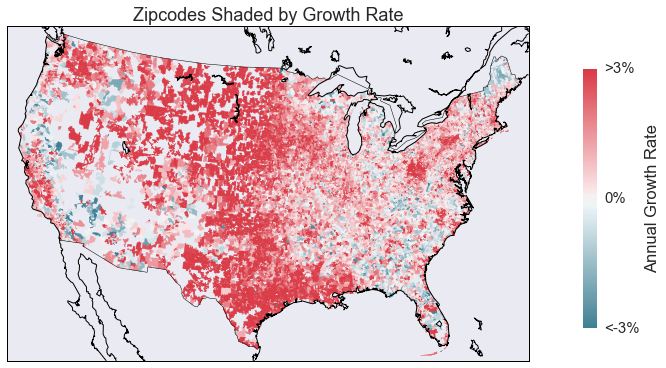

In [40]:
draw_map(plot_data,.1,.9, True)

## Next Step: Predict Growth Rate Using Other Categories

* The tax return contains a lot of other information besides income: investments, foreign taxes paid, etc. 

* Which of these features can be used as predictors of growth rate?

* Can the past history predict future growth?

* Machine learning models likely to be helpful.

In [18]:
model_df = tax_data['14'].groupby('zipcode').sum().reset_index().merge(agi_data.growth_coef.reset_index(), on = 'zipcode')
model_df = model_df.drop(['zipcode','statefips','agi_stub'],axis=1)
model_df = model_df.drop(0)
model_df.head()

,num_returns,mars1,mars2,mars4,prep,num_exemp,numdep,total_vita,vita,tce,...,a10300,n85530,a85530,n85300,a85300,n11901,a11901,n11902,a11902,growth_coef
1,9640.0,5240.0,3510.0,760.0,4710.0,16540.0,4290.0,360.0,250.0,110.0,...,120298.0,290.0,367.0,460.0,2038.0,2340.0,11950.0,6610.0,17677.0,0.008465
2,2280.0,1100.0,970.0,190.0,1250.0,4220.0,1180.0,0.0,0.0,0.0,...,14130.0,0.0,0.0,0.0,0.0,450.0,1484.0,1730.0,4218.0,0.007291
3,7390.0,3420.0,3280.0,570.0,3780.0,14000.0,4140.0,140.0,40.0,100.0,...,62907.0,110.0,117.0,130.0,225.0,1390.0,5786.0,5690.0,14708.0,0.018211
4,640.0,280.0,310.0,40.0,350.0,1190.0,290.0,0.0,0.0,0.0,...,4380.0,0.0,0.0,0.0,0.0,120.0,592.0,500.0,1140.0,0.006843
5,1840.0,850.0,850.0,130.0,1030.0,3500.0,960.0,0.0,0.0,0.0,...,16694.0,20.0,21.0,30.0,38.0,390.0,1769.0,1370.0,3413.0,0.008822


{'alpha': 1.4500000000000002}


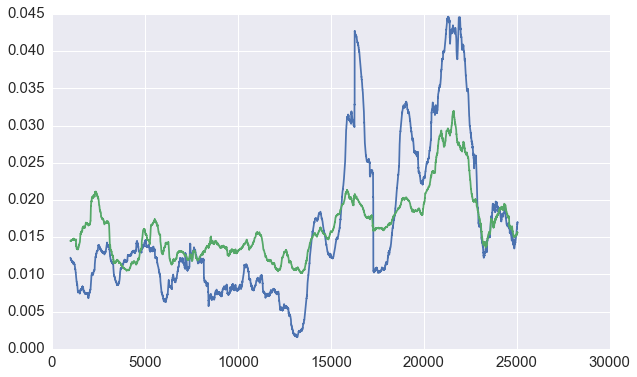

CPU times: user 3.12 s, sys: 893 ms, total: 4.01 s
Wall time: 4.16 s


In [27]:
%%time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.linear_model import Ridge

X = model_df.dropna().copy()
X = X.drop('growth_coef', axis=1)
#X['Child Tax Credits Amount'] =  X['A11070']+X['A07220']
#X['Child Tax Credits Number'] =  X['N11070']+X['N07220']
#X = X.drop(['agi_per_exemp','agi_per_return', 'A05800', 'A04800', 'N04800', 'N05800', 'A06500', 'N06500',\
#            'A10300', 'N10300', 'A11902', 'N11902', 'A10600', 'N10600', 'A59660', 'N59660', 'A59720', 'N59720',\
#                  'N11070', 'A11070', 'A07220', 'N07220', 'A02650', 'N02650', 'A00101'],axis=1)
#X = X[['num_returns', 'MARS2', 'A01000', 'PREP', 'A00300', 'A10600']]
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
Y = model_df.dropna().growth_coef

mod = Ridge(alpha=1)

gs = sklearn.model_selection.GridSearchCV(
    mod,
    {"alpha": np.arange(1.3,1.5,.05)},
    cv=5,  # 5-fold cross validation
    n_jobs=1,  # run each hyperparameter in one of two parallel jobs
)
gs.fit(X, Y)
print gs.best_params_

plt.plot(pd.Series.rolling(pd.Series(Y), window=1000).mean())
plt.plot(pd.Series.rolling(pd.Series(gs.predict(X)), window=1000).mean())
plt.show()

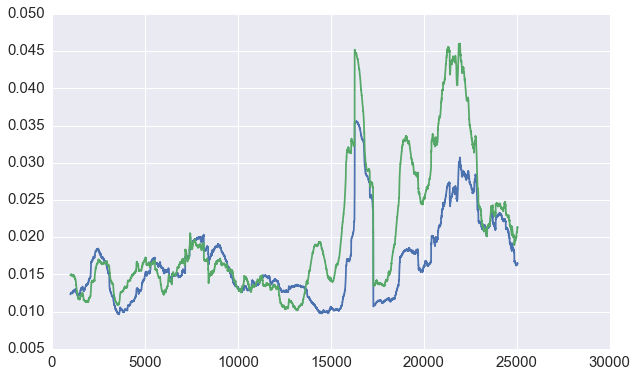

In [43]:
plt.plot(pd.Series.rolling(pd.Series(np.abs(gs.predict(X)-Y)), window=1000).mean())
plt.plot(pd.Series.rolling(pd.Series(np.abs(Y)), window=1000).mean())
plt.show()

In [36]:
model_df.corr().growth_coef.sort_values()

tce           -0.014485
a59720        -0.013744
a59660        -0.012003
n59720        -0.011468
n59660        -0.009234
n02500        -0.005516
mars4         -0.005400
a07240        -0.005111
n07240        -0.004577
total_vita    -0.003892
n01700        -0.003816
n11070        -0.003734
n02300        -0.001410
a11070        -0.000590
a85770         0.001568
a01700         0.002120
a85775         0.002461
a02500         0.005034
n01400         0.005346
vita           0.005553
n85770         0.005568
n07260         0.005652
a10960         0.005713
a02300         0.006583
n85775         0.007705
n10960         0.007722
n05780         0.009178
n11560         0.010088
a07260         0.013140
a05780         0.013675
                 ...   
a04470         0.055234
n01000         0.055480
a85300         0.055730
a26270         0.056118
a18450         0.057242
a07100         0.057945
a01000         0.058484
n03300         0.059248
n03270         0.059757
n26270         0.060673
n03240         0

The most important features are
1. the fraction of returns with investement income
2. the fraction of AGI coming from wages
3. the fraction of single returns (as opposed to joint or head-of-household)
4. the number of dependents per return

To look at these features in greater depth, we analyze their correlations with each other and with AGI per Exemption. That is done in the following plots:

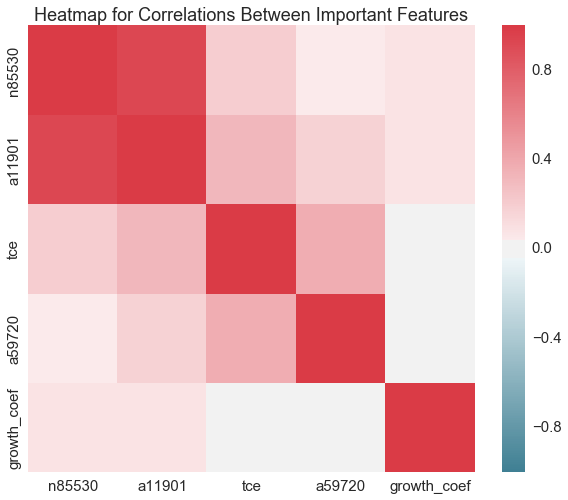

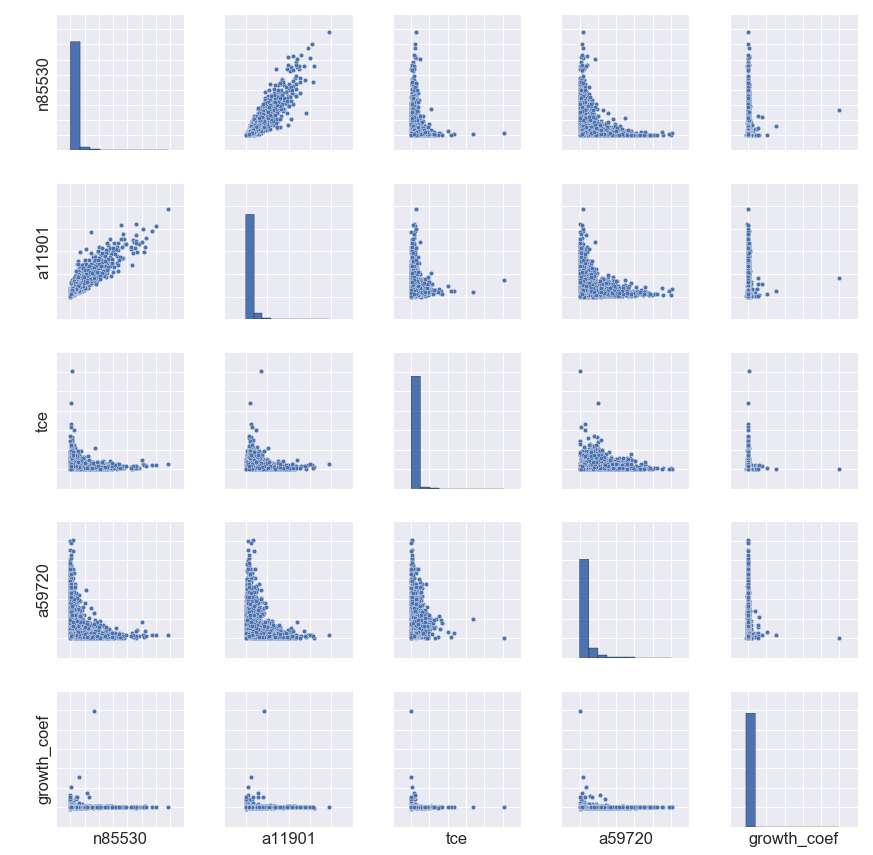

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

imp_features = ['n85530', 'a11901', 'tce', 'a59720', 'a06500']
f, ax = plt.subplots(figsize=(10, 8))
corr = model_df[imp_features[:4] + ['growth_coef']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Heatmap for Correlations Between Important Features')
plt.show()
pp = sns.pairplot( model_df[imp_features[:4] + ['growth_coef']])
for i in range(5):
    plt.setp(pp.axes[i,0].get_yticklabels(), visible=False)
    plt.setp(pp.axes[4,i].get_xticklabels(), visible=False)
plt.show()

* % w/Investements has the highest correlation coefficient with AGI/Exemption out of all features at 0.85.
* Wages/AGI has the largest-in-magnitude negative correlation at -0.41
* % Single and Dependents/Return are well-correlated with each other and have moderate correlations with AGI/Exemption.
    * Perhaps their combined effect is useful for the model?

In [425]:
model_df.drop(['A05800', 'A04800', 'N04800', 'N05800', 'A06500', 'N06500',\
            'A10300', 'N10300', 'A11902', 'N11902', 'A10600', 'N10600', 'A59660', 'N59660', 'A59720', 'N59720',\
                  'N11070', 'A11070', 'A07220', 'N07220', 'A02650', 'N02650', 'A00101']\
              ,axis=1).corr()['AGI/Exemption'].sort_values()

Wages/AGI               -0.417463
A07240                  -0.347077
MARS4                   -0.284305
N07240                  -0.284098
Dependents/Return       -0.275193
A09750                  -0.273591
Total Credits/AGI       -0.255051
Exemptions per Return   -0.253412
A01700                  -0.247826
A02300                  -0.213330
N09750                  -0.208677
A10960                  -0.206399
% w/ Wages              -0.201249
A07230                  -0.189273
SS Benefits/AGI         -0.175415
A85775                  -0.132039
A85770                  -0.131399
N02300                  -0.131045
SCHF                    -0.124864
A03210                  -0.122230
A07180                  -0.109196
A03220                  -0.079168
A05780                  -0.051240
N10960                  -0.041112
A11560                  -0.036917
A09400                  -0.011743
N85770                   0.003635
A07260                   0.010560
A03230                   0.015165
N85775        

In [462]:
test = data[year].groupby('zipcode').sum()[['num_returns', 'num_exemp', 'agi']]
test['agi_per_exemp'] = test.agi/test.num_exemp
test[test['agi_per_exemp'] > 128].sum()/test.sum()

num_returns      0.007320
num_exemp        0.006445
agi              0.037583
agi_per_exemp    0.068800
dtype: float64

In [465]:
test[test['agi_per_exemp'] > 1200]

,num_returns,num_exemp,agi,agi_per_exemp
zipcode,,,,
33109,240.0,470.0,585911.0,1246.619149


In [5]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)
import os
os.system('jupyter-nbconvert --to slides DataINcubatorProjectv3.ipynb --reveal-prefix=reveal.js --post serve')

256